## Load data

In [2]:
import numpy as np
import _pickle as pkl
import torch
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_9985E1798153438E880A8AD60B9146FE.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("test"),
 'device': 'cuda:0',
 'n_examples': 5,
 'n_predictions': 6,
})

In [4]:
with open(args.dataset_path, 'rb') as f:
    data = pkl.load(f)

imgs_rgb = torch.from_numpy(data["img"]).to(device=args.device).float()
imgs_gray = torch.from_numpy(rgb2gray(data["img"]).transpose(0, 1, 4, 2, 3)).to(device=args.device).float()
ft = torch.from_numpy(data["ft"]).to(device=args.device).float()
arm = torch.from_numpy(data["arm"]).to(device=args.device).float()
actions = torch.from_numpy(data["action"]).to(device=args.device).float()

## Visualize

In [5]:
from utils import load_models, load_vh_models, frame_stack
from argparse import Namespace
import json
import torch.nn as nn

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/test/2D_lightTCN_base_gru_lm_vha
torch.Size([5, 16])
torch.Size([5, 7, 16])


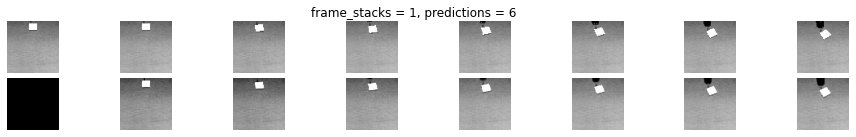

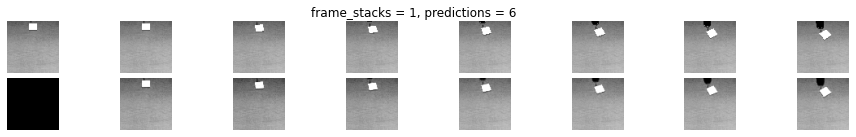

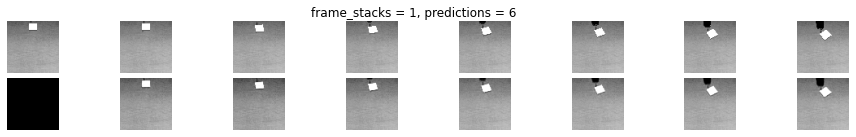

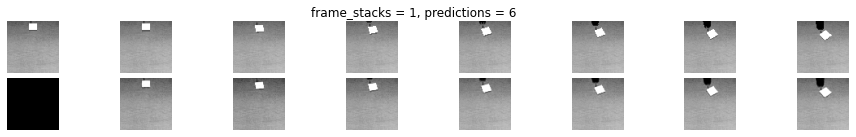

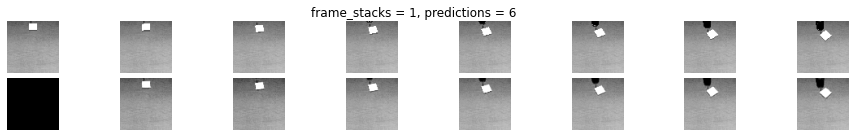

In [8]:
models = {}

# Load hyperparameters from trained model
for filedir in os.listdir(args.models_dir):
    fullpath = os.path.join(args.models_dir, filedir)
    if os.path.isdir(fullpath):
        models[fullpath] = {}
        with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
            models[fullpath]['hyperparameters'] = Namespace(**json.load(fp))


with torch.no_grad():
    for path, model in models.items():
        model_args = model['hyperparameters']
        if model_args.dim_x[0] == 1:
            imgs = imgs_gray
        elif model_args.dim_x[0] == 3:
            imgs = imgs_rgb
        ii = np.random.randint(imgs.shape[0] // args.n_examples)
        total_len = imgs.shape[1]
        T = model_args.frame_stacks
        start_idx = np.random.randint(total_len - args.n_predictions - T)

        u_f = actions[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            (T + 1):(T + 1 + args.n_predictions)
        ] 
        
        x = imgs[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_i = imgs[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1)
        ] 
        x_i = frame_stack(x_i, frames=T)  

        x_ft = ft[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_ft_i = ft[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            T:(T + 1)
        ]

        x_arm = arm[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_arm_i = arm[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            T:(T + 1)
        ]

        models = load_vh_models(path, model_args, mode='eval', device=args.device)
        
        # Roll-out or predictions
        z_all = []
        if model_args.use_img_enc:
            z_all.append(models["img_enc"](x_i.reshape(-1, *x_i.shape[2:])))

        if model_args.use_joint_enc:
            joint_inp = torch.cat((
                x_ft_i.reshape(-1, *x_ft_i.shape[2:]), 
                x_arm_i.reshape(-1, *x_arm_i.shape[2:])), 
                dim=-1
            )
            z_all.append(models["joint_enc"](joint_inp)[:, -1])
        else:
            if model_args.use_haptic_enc:
                z_all.append(models["haptic_enc"](x_ft_i.reshape(-1, *x_ft_i.shape[2:]))[:, -1])
            if model_args.use_arm_enc:
                z_all.append(models["arm_enc"](x_arm_i.reshape(-1, *x_arm_i.shape[2:]))[:, -1])
            
        z_cat_i = torch.cat(z_all, dim=1)
        z_i, mu_z_i, logvar_z_i = models["mix"](z_cat_i)
        var_z_i = torch.diag_embed(torch.exp(logvar_z_i))
        h_i = None

        z_hat = torch.zeros((args.n_examples, (1 + args.n_predictions), model_args.dim_z)).to(device=args.device)
        z_hat[:, 0] = z_i

        for jj in range(args.n_predictions):
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = models["dyn"](
                z_t=z_i, 
                mu_t=mu_z_i, 
                var_t=var_z_i, 
                u=u_f[:, jj], 
                h=h_i, 
                single=True
            )

            z_hat[:, jj + 1] = mu_z_ip1
            z_i, mu_z_i, var_z_i, h_i = z_ip1, mu_z_ip1, var_z_ip1, h_ip1    
        
        print(z_hat.shape)
        # Decode predictions
        x_hat = models["img_dec"](z_hat.reshape(-1, *z_hat.shape[2:]))
        x_hat = x_hat.reshape(args.n_examples, (args.n_predictions + 1), *x_hat.shape[1:])
            
        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x = x.cpu().numpy()

        # Plotting
        for bb in range(args.n_examples):
            columns = T + 1 + args.n_predictions
            rows = 2
            fig=plt.figure(figsize=(16, 2))
            fig.suptitle('frame_stacks = {}, predictions = {}'.format(T, args.n_predictions))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-1,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                
                plt.axis('off')
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.show()